# Starting notes
This is an example of using Julia and Spectra.jl with the optimisation framework JuMP and algorithm Ipopt to solve a problem related to the measurement of a diffusion profil with Infrared.

Spectra have been measured along one axis of a cystal, and we expect diffusion of water along this axis.

We are going to treat all the data in once. First, we are going to put the data in good shape for the optimisation procedure, which consist in peak-fitting all the spectra with Gaussian peaks, the amplitudes of the latters being calculated from the 1D diffusion equation.

The data are entered as a [x y1 y2 y3 ... yn] text file, and the parameters are read in a second text file. Basically, to adjust anything you only need to modify this parameter text file. 

INFO: Recompiling stale cache file /home/juser/.julia/lib/v0.4/JuMP.ji for module JuMP.


Done


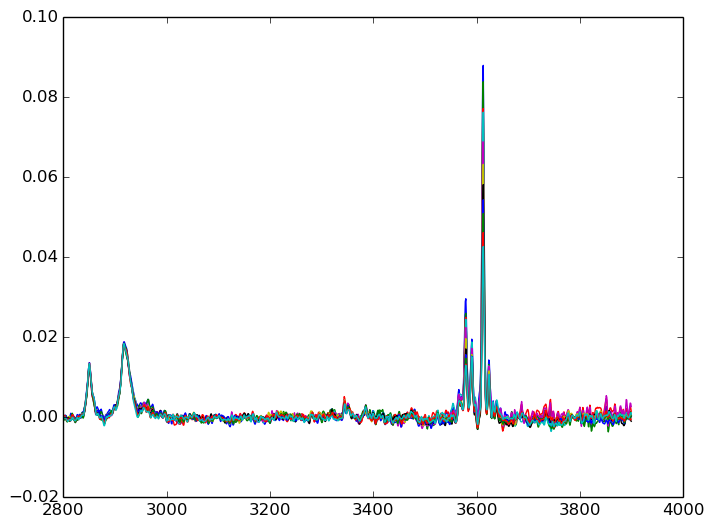

In [2]:
# we call the relevant libraries
#Pkg.update() #better to run that at the beginning of any session
using PyPlot
using JuMP
using Ipopt
using Spectra

# you need to modify the following three lines depending on the files location (should be standard in this example)
data = readdlm("./data/Fo_exp6_P5.txt", '\t') #reading the data
parameters = readdlm("./data/Fo_exp6_P5_params.txt", '\t') #reading the parametersthe experience details
plot(data[find(2800 .< data[:,1] .<3900),1],data[find(2800 .< data[:,1] .<3900),25:35]) # quick look to select the point of departure of the profil more easily, comment if you don't want it

# here is just some stuffs to get parameters in the right variables
step = Float64(parameters[1,2]) #step is in metre
time = Float64(parameters[2,2].*3600.0) #time is in seconds, convert the hours of the user input
start_sp = Int64(parameters[3,2]) #first valid spectra along profil (at the border)
stop_sp = Int64(parameters[4,2]) #last valid spectra along profil (at the centre)
low_x = Float64(parameters[5,2]) #low frequency of roi (region of interest)
high_x = Float64(parameters[6,2]) #high frequency of roi (region of interest)
first_bound_norm = Float64(parameters[7,2]) #low bond of integration for normalisation
second_bound_norm = Float64(parameters[8,2]) #high bond of integration for normalisation
first_bound_err = Float64(parameters[9,2]) #low bond of integration for error estimation
last_bound_err = Float64(parameters[10,2]) #high bond of integration for error estimation
m = Int64(parameters[11,2]) #number_peaks
# We read the array of the model parameters and suqeeze them in 1D to have vectors
c0_guess = squeeze(readdlm(IOBuffer(parameters[12,2]),','),1) #Initial concentrations
c1_guess = squeeze(readdlm(IOBuffer(parameters[13,2]),','),1) #Bondary concentrations
D_guess = squeeze(readdlm(IOBuffer(parameters[14,2]),','),1) #Diffisivity coefficients
freq_guess = squeeze(readdlm(IOBuffer(parameters[15,2]),','),1) #Frequencies of the peaks
hwhm_guess = squeeze(readdlm(IOBuffer(parameters[16,2]),','),1) #HWHM of the peaks

println("Done")

In [3]:
# We prepare the data for the fit with the IRdataprep function of Spectra.jl
x, y, y_ese_r, x_fit, y_fit, ese_fit = IRdataprep(data,step,start_sp,stop_sp,low_x,high_x,first_bound_norm,second_bound_norm, first_bound_err, last_bound_err)
# to avoid any true 0 values and bring y values close to 1
y = y .*10000 + 1e-20
y_fit = y_fit .*10000 + 1e-20
ese_fit = ese_fit .* 10000 + 1e-20
println("Done")

Done


Now, the data are in a good shape, such that we only need to build the model using JuMP. This is quite straightforward:

In [4]:
# we construct a user-defined function
myf(x,y,t,dist,c0,c1,D,F,HW) = (((c1 - c0) * erfc(dist/(2. * ( 10^D * t)^0.5)) + c0) *exp(-log(2) * ((x-F)/HW)^2) - y)^2 
registerNLFunction(:gauss_diff, 9, myf, autodiff=true)

# number of data =
n = size(x_fit)[1]

#mod = Model(solver=IpoptSolver(derivative_test_print_all="yes",derivative_test="first-order")) # here we build the model
mod = Model(solver=IpoptSolver()) # here we build the model

#Parameters declaration, remember that m is the number of peaks
@defVar(mod, 1e-10 <= g_co[i=1:m] <= maximum(y_fit))
@defVar(mod, 1e-10 <= g_c1[i=1:m] <= maximum(y_fit))
@defVar(mod, -20.0 <= g_D[i=1:m] <= 0.1 )
@defVar(mod, 3500.0 <= g_freq[i=1:m] <= 3700.0 )
@defVar(mod, 0.1 <= g_hwhm[i=1:m] <= 20.0 )

#Parameters initialisation
setValue(g_co[i=1:m],c0_guess)
setValue(g_c1[i=1:m],c1_guess)
setValue(g_D[i=1:m],D_guess)
setValue(g_freq[i=1:m],freq_guess)
setValue(g_hwhm[i=1:m],hwhm_guess)

#@defNLParam(mod,g_co[i=1:m] == c0_guess[i] )
#@defNLParam(mod,g_c1[i=1:m] == c1_guess[i] )
#@defNLParam(mod, g_D[i=1:m] == D_guess[i] )
#@defNLParam(mod, g_freq[i=1:m] == freq_guess[i] )
#@defNLParam(mod, g_hwhm[i=1:m] == hwhm_guess[i] )

# The expression of the gaussians
#@defNLExpr(mod, g_mod[j=1:n],sum{((g_c1[i] - g_co[i]) * erfc(x_fit[j,1]/(2. * ( 10^g_D[i] * time)^0.5)) + g_co[i]) *exp(-log(2) * ((x_fit[j,2]-g_freq[i])/g_hwhm[i])^2), i=1:m}) 
#@defNLExpr(mod, g_mod[j=1:n],sum{((g_c1[i] - g_co[i]) * (x_fit[j,1]/(2. * ( 10^g_D[i] * time))) + g_co[i]) *exp(-log(2) * ((x_fit[j,2]-g_freq[i])/g_hwhm[i])^2), i=1:m}) 
@defNLExpr(mod, g_mod[j=1:n],sum{gauss_diff(x_fit[j,2],y_fit[j,1],time,x_fit[j,1],g_co[i],g_c1[i],g_D[i],g_freq[i],g_hwhm[i]), i=1:m}) 


# The objective function to solve, i.e. the simple least-square function
@setNLObjective(mod,Min,sum{g_mod[j], j=1:n})
println("Constructed...")
println(mod)

Constructed...
Min (nonlinear expression)
Subject to
 1.0e-10 ≤ g_co[i] ≤ 0.00031904302098927084 ∀ i ∈ {1,2,…,4,5}
 1.0e-10 ≤ g_c1[i] ≤ 0.00031904302098927084 ∀ i ∈ {1,2,…,4,5}
 -20 ≤ g_D[i] ≤ 0.1 ∀ i ∈ {1,2,…,4,5}
 3500 ≤ g_freq[i] ≤ 3700 ∀ i ∈ {1,2,…,4,5}
 0.1 ≤ g_hwhm[i] ≤ 20 ∀ i ∈ {1,2,…,4,5}



We now plot the data to see how looks like the initial model. If not good, we can update the parameter file. Please note that there is so many spectra in along this diffusion profile that it is not very relevant to plot them in 3D.

I prefer selecting a particular spectra, through the selected_spectrum variable, in order to have a clear look at the model in 2D. Change this selected_spectrum value to move along your diffusion profile (low value: close to border, high, close to core).

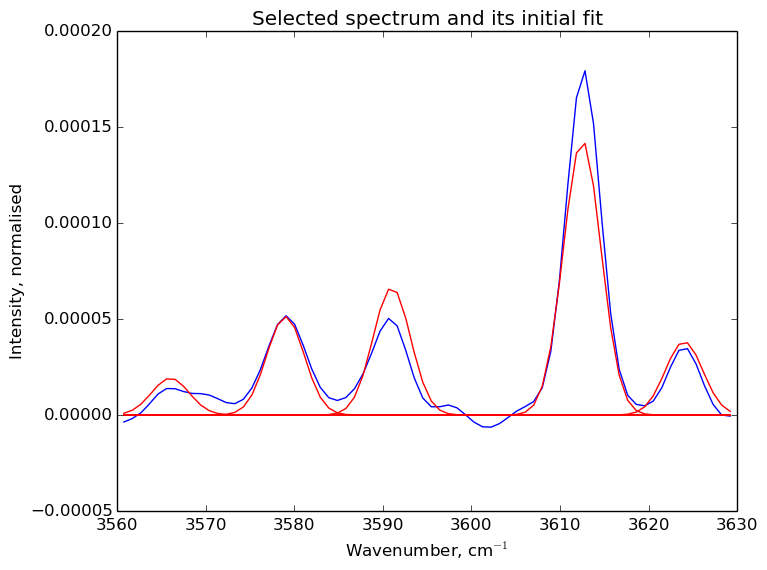

PyObject <matplotlib.text.Text object at 0x7f8646f72b10>

In [5]:
# parameter extractions
mod_co = getValue(g_co)
mod_c1 = getValue(g_c1)
mod_D = getValue(g_D)
mod_f = getValue(g_freq)
mod_hwhm = getValue(g_hwhm)

selected_spectrum = 10 #for peak fitting figures
model,peaks = peak_diffusion(mod_co, mod_c1, mod_D, mod_f, mod_hwhm, x_fit, time)
interest_compos = peaks[selected_spectrum*length(x)+1:selected_spectrum*length(x)+length(x),:]

fig = figure()
#plot(x, y[:,:],color="black",label="All profil")
plot(x, y[:,selected_spectrum],color="blue",label="SOI")
plot(x,interest_compos[:,:],color="red",label="Guess fit")
title("Selected spectrum and its initial fit")
xlabel(L"Wavenumber, cm$^{-1}$")
ylabel("Intensity, normalised")


And we launch the optimisation procedure with the Ipopt algorithm.

In [ ]:
# Solve for the control and state
println("Solving...")
status = solve(mod)

# Display results
println("Solver status: ", status)
println("rmsd: ", getObjectiveValue(mod))

Solving...


We have a good solution. Let's see now how things look like. Same comment as above for the 2D plot.

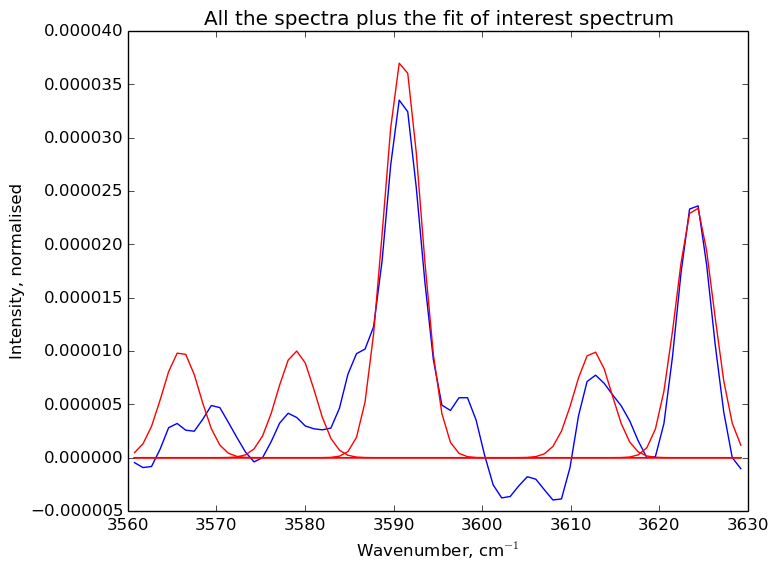

PyObject <matplotlib.text.Text object at 0x7f649a175290>

In [6]:
# parameter extractions
mod_co_f = getValue(g_co)
mod_c1_f = getValue(g_c1)
mod_D_f = getValue(g_D)
mod_f_f = getValue(g_freq)
mod_hwhm_f = getValue(g_hwhm)

selected_spectrum = 100 #for peak fitting figures
model,peaks = peak_diffusion(mod_co_f, mod_c1_f, mod_D_f, mod_f_f, mod_hwhm_f, x_fit, time)
interest_compos = peaks[selected_spectrum*length(x)+1:selected_spectrum*length(x)+length(x),:]

fig = figure()
#plot(x, y[:,:],color="black",label="All profil")
plot(x, y[:,selected_spectrum],color="blue",label="SOI")
plot(x,interest_compos[:,:],color="red",label="Guess fit")
title("All the spectra plus the fit of interest spectrum")
xlabel(L"Wavenumber, cm$^{-1}$")
ylabel("Intensity, normalised")

In [7]:
println("c0 are $(mod_co_f)")
println("c1 are $(mod_c1_f)")
println("D are $(mod_D_f)")
println("frequency are $(mod_f_f)")
println("hwhm are $(mod_hwhm_f)")

c0 are [1.0e-5,1.0e-5,1.0e-5,1.0e-5,1.0e-5]
c1 are [3.0e-5,0.0001,7.0e-5,0.0003,4.0e-5]
D are [-13.5,-13.5,-11.5,-13.5,-11.5]
frequency are [3566.0,3579.0,3591.0,3612.5,3624.0]
hwhm are [2.5,2.5,2.5,2.5,2.5]


INFO: Updating METADATA...
INFO: Updating cache of StatsBase...
INFO: Computing changes...
INFO: Upgrading StatsBase: v0.7.4 => v0.8.0
INFO: Checking out JuMP master...
INFO: Pulling JuMP latest master...
INFO: No packages to install, update or remove
INFO: Checking out Ipopt master...
INFO: Pulling Ipopt latest master...
INFO: No packages to install, update or remove
